In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid 
from torchvision.models import resnet50, ResNet50_Weights, vgg19, VGG19_Weights
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import utils
from models import Classificator

## Hyperparameters

In [2]:
#Dataloader params
BATCH_SIZE = 32
NUM_WORKERS = 1 # 7 because that what it suggested in a warning message
PERSISTENT_WORKERS = True # Suggested to do this in a warning message for faster init
USE_AUGMENT = False
CUSTOM_TRAIN_VAL_SPLIT = True
DATA_DIR = "chest_xray" # Change this to chest_xray folder
USE_SAMPLER = False
SHOW_ANALYTICS = False

# Lightning moduls params
LEARNING_RATE = 1e-3
CLASS_NUM = 2
EPOCHS = 10
CLASS_LABELS = ["Normal", "Pneumonia"]
NUM_CLASSES = 2
SIGMOID_OUT = False 

MODEL_TO_USE = "resnet50" #Can either be "resnet50" or "vgg19"

config = {
    "lr": LEARNING_RATE,
    "loss": "CrossEntropyLoss"
}



## Load data

In [3]:
train_loader, val_loader, test_loader = utils.loadData(
    batchSize=BATCH_SIZE,
    numWorkers=NUM_WORKERS,
    dataDir=DATA_DIR,
    customSplit=CUSTOM_TRAIN_VAL_SPLIT,
    useAugment=USE_AUGMENT,
    useSampler=USE_SAMPLER,
    showAnalytics=SHOW_ANALYTICS
)

## Plot some example images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0, 1, 1],
        [0, 1, 0],
        [1, 0, 1]])


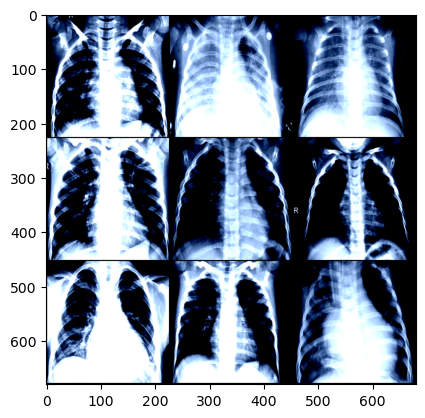

In [4]:
examples = next(iter(train_loader))
images, labels = examples
grid = make_grid(images[:9], nrow=3)
plt.imshow(grid.permute(1, 2, 0))
print(labels[:9].reshape(3,3))

## Load model

In [5]:
if MODEL_TO_USE == "resnet50":
    model = resnet50(weights=ResNet50_Weights.DEFAULT)
    if SIGMOID_OUT:
        model.fc = nn.Sequential(
            torch.nn.Linear(
            in_features=2048,
            out_features=NUM_CLASSES,
            bias=True
            ), 
            nn.Sigmoid()
        )
    else:
        model.fc = torch.nn.Linear(
            in_features=2048,
            out_features=NUM_CLASSES,
            bias=True
        )
    #Freeze all layers except fc
    for name, param in model.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    if SIGMOID_OUT:
        for param in model.fc.parameters():
            param.requires_grad = True

elif MODEL_TO_USE == "vgg19":
    model = vgg19(weights=VGG19_Weights.DEFAULT)
    #Freeze everything
    for param in model.parameters():
        param.requires_grad = False
    #Unfreeze fc2
    for param in model.classifier[3].parameters():
        param.requires_grad = True
    model.classifier[6] = nn.Linear(4096, NUM_CLASSES)
    for param in model.classifier[6].parameters():
        param.requires_grad = True

## Run training and validation loops

In [6]:
classifier = Classificator(model, CLASS_LABELS, config, NUM_CLASSES)
early_stop_callback = EarlyStopping(monitor="Validation loss", min_delta=1e-6, patience=10)
checkpoint = L.pytorch.callbacks.ModelCheckpoint(dirpath="pneumonia_model/ResNet/")
callbacks = [early_stop_callback, checkpoint]
logger = TensorBoardLogger("lightning_logs",
                           name=f"resnet/augment{USE_AUGMENT}_sigmoid{SIGMOID_OUT}_{MODEL_TO_USE}",
                           )

trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    logger=logger,
    max_epochs=EPOCHS,
    reload_dataloaders_every_n_epochs=3,
    callbacks=callbacks
)
trainer.fit(
    model = classifier,
    train_dataloaders = train_loader, 
    val_dataloaders = val_loader
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/emillundin/Desktop/D7047E/D7047E-Project/D7047E-Project/pneumonia_model/ResNet exists and is not empty.

  | Name                  | Type                  | Params
----------------------------------------------------------------
0 | CNN                   | ResNet                | 23.5 M
1 | loss                  | CrossEntropyLoss      | 0     
2 | val_confusion_matrix  | BinaryConfusionMatrix | 0     
3 | test_confusion_matrix | BinaryConfusionMatrix | 0     
4 | train_metrics         | MetricCollection      | 0     
5 | valid_metrics         | MetricCollection      | 0     
6 | test_metrics          | MetricCollection      | 0     
----------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Test model
Only implemented and tested but should not use until final model is decided

In [12]:
trainer.test(model = classifier, dataloaders=test_loader, ckpt_path="best")

Restoring states from the checkpoint path at /Users/emillundin/Desktop/D7047E/D7047E-Project/D7047E-Project/pneumonia_model/ResNet/epoch=9-step=1310-v2.ckpt
Loaded model weights from the checkpoint at /Users/emillundin/Desktop/D7047E/D7047E-Project/D7047E-Project/pneumonia_model/ResNet/epoch=9-step=1310-v2.ckpt
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Test loss         │     0.332297682762146     │
│    test_BinaryAccuracy    │    0.7636301517486572     │
│    test_BinaryF1Score     │    0.48513519763946533    │
│   test_BinaryPrecision    │    0.40968087315559387    │
│     test_BinaryRecall     │    0.6295749545097351     │
└───────────────────────────┴───────────────────────────┘

[{'Test loss': 0.332297682762146,
  'test_BinaryPrecision': 0.40968087315559387,
  'test_BinaryRecall': 0.6295749545097351,
  'test_BinaryF1Score': 0.48513519763946533,
  'test_BinaryAccuracy': 0.7636301517486572}]

In [10]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 46915), started 18:11:22 ago. (Use '!kill 46915' to kill it.)